# Библиотеки

In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import NLTKWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
import re

import os
import gensim.downloader as api
from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Загружаем данные

In [294]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [295]:
df = pd.read_csv('/content/drive/MyDrive/lectures/natural lang/dz_1/train.csv', index_col=0)

# EDA (Exploratory Data Analysis)

In [296]:
df.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


In [298]:
df.isna().sum()

Text         1
Sentiment    4
dtype: int64

In [299]:
df = df.dropna()
df.isna().sum()

Text         0
Sentiment    0
dtype: int64

In [300]:
class_distribution = df['Sentiment'].value_counts()
class_distribution

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Оценим распредление классов на графике

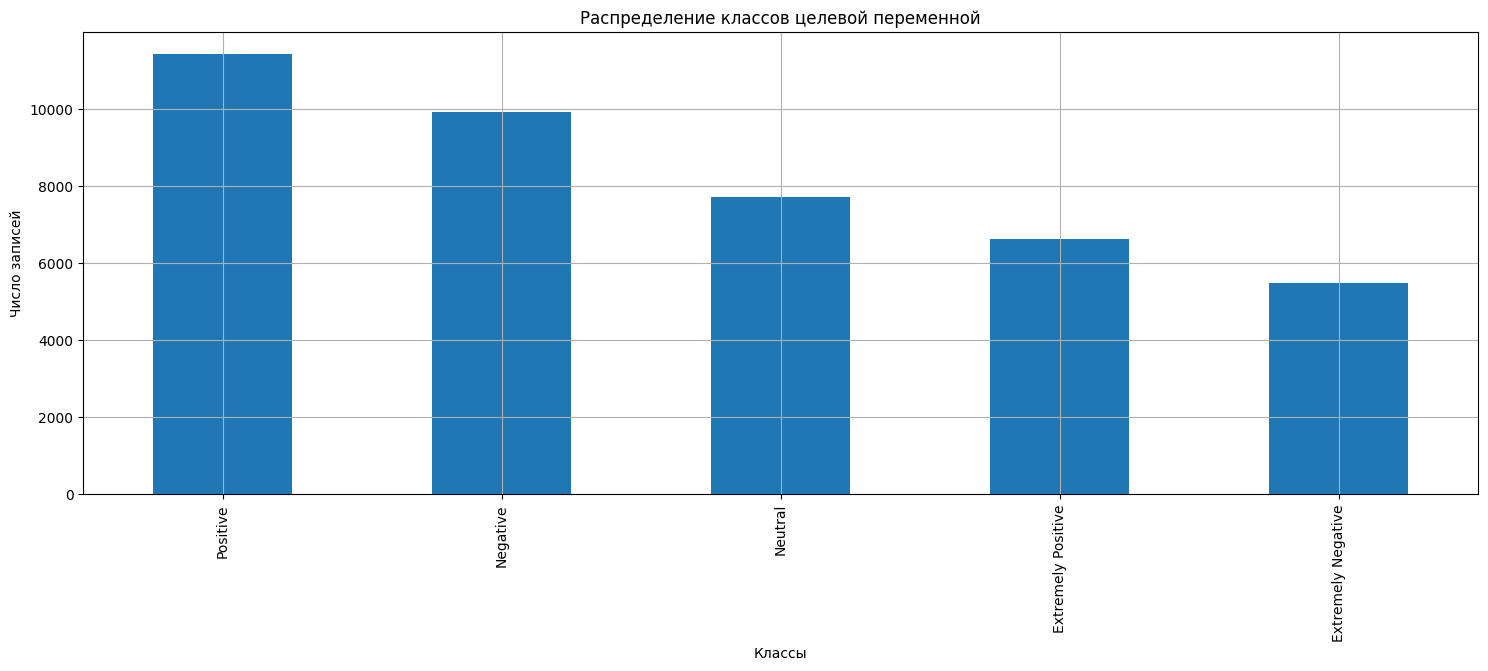

In [301]:
class_distribution.plot(kind='bar')
plt.title('Распределение классов целевой переменной')
plt.xlabel('Классы')
plt.ylabel('Число записей')
plt.grid(True)
plt.show()

Сильного дисбаланса нет. Посмотрим теперь на длинну текста

Количество символов в тексте

In [302]:
def get_text_lenght(text):
  return len(text)

In [303]:
df['length_text'] = df['Text'].apply(get_text_lenght)

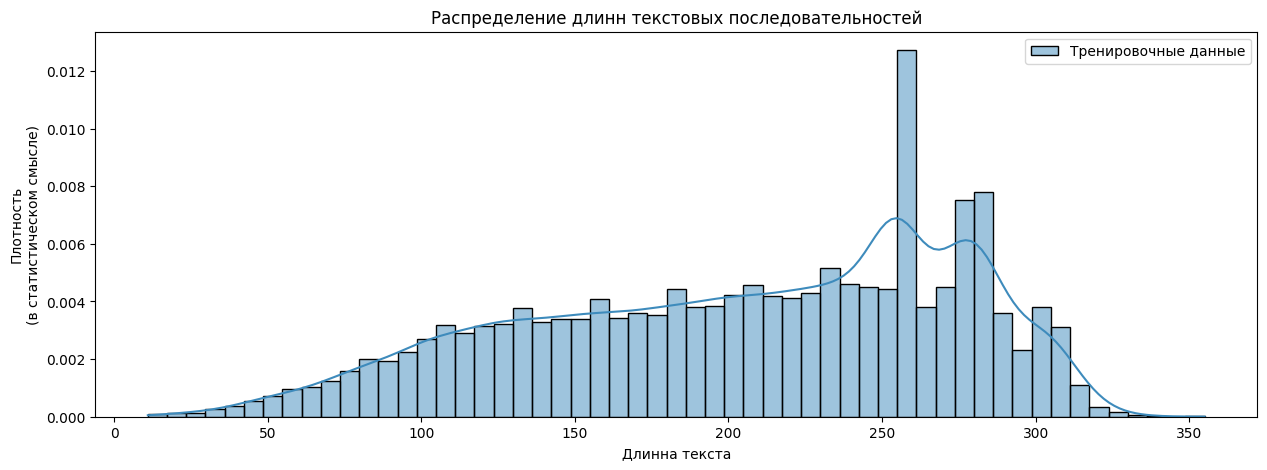

In [304]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['length_text'], ax=ax, kde=True, label='Тренировочные данные', color='#3e8bbc', stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн текстовых последовательностей')
plt.show()

Сильных смещений нет. Далее проведем токинизацию и посмотрим на распределения токенов.

Количество слов в тексте

In [305]:
text_len = df['Text'].str.split().map(lambda x: len(x))

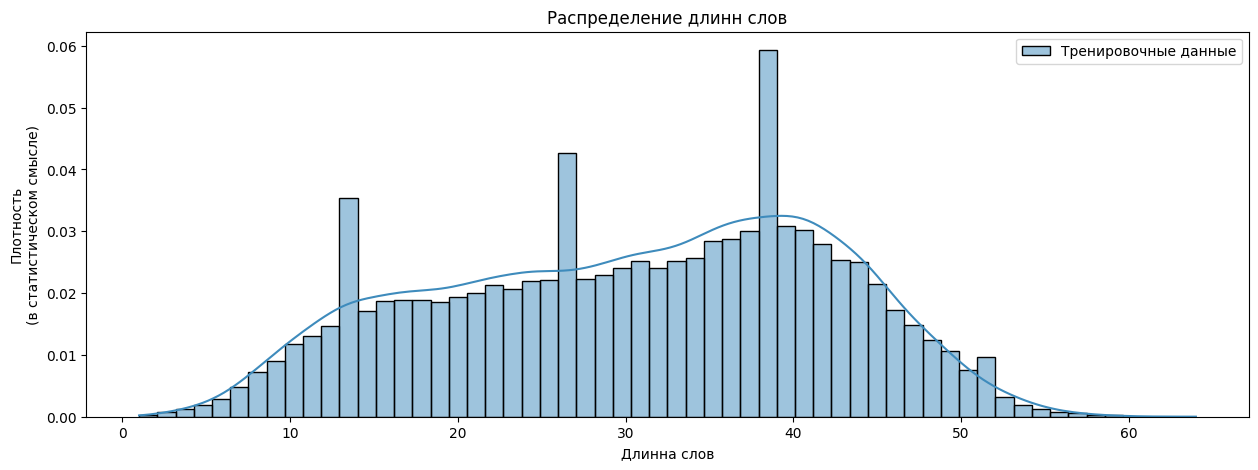

In [306]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(text_len, ax=ax, kde=True, label='Тренировочные данные', color='#3e8bbc', stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна слов')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн слов')
plt.show()

Длины слов визуально довольно нормально распределены, кроме небольших выбросов, возможно связаных с больших количеством слов косамемых коронавируса

# Препроцессинг

## Список Аббревеатур

In [307]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

## Очистка текста

In [308]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [309]:
def convert_abbrev_in_text(text):
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [310]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [311]:
stopwords = nltk.corpus.stopwords.words('english')

#Removing the stopwords
def remove_stopwords(text):
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [312]:
#Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [313]:
#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [314]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [315]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [316]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [317]:
#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [318]:
# Функция для очистки и токенизации текста
def preprocess(text):
    text = text.lower() #Lets make it lowercase
    text = remove_URL(text)
    text = remove_emoji(text)
    text = denoise_text(text)
    text = convert_abbrev_in_text(text)
    text = remove_stopwords(text)
    text = remove_punct(text)
    text = remove_special_characters(text)
    return text

In [319]:
df['Text_preprocessed'] = df['Text'].apply(preprocess)

<ipython-input-314-938e610e499c>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [320]:
df.head()

,Text,Sentiment,length_text,Text_preprocessed
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,237,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,coronavirus australia woolworths give elderly...
3,My food stock is not the only one which is emp...,Positive,306,food stock one empty please nt panic enough...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,ready go supermarket covid19 outbreak m para...


In [321]:
df.count()

Text                 41155
Sentiment            41155
length_text          41155
Text_preprocessed    41155
dtype: int64

In [322]:
df['length_text_preprocessed'] = df['Text_preprocessed'].apply(get_text_lenght)

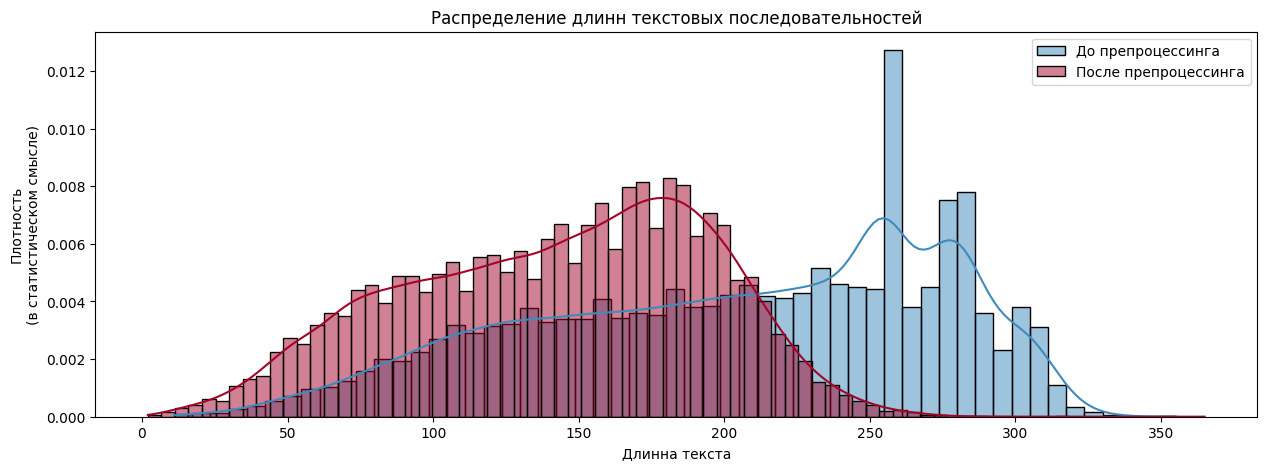

In [323]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['length_text'],
             ax=ax, kde=True,
             label='До препроцессинга',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['length_text_preprocessed'],
             ax=ax, kde=True,
             label='После препроцессинга',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн текстовых последовательностей')
plt.show()

Исходя из графика длину сообщения можно брать 250

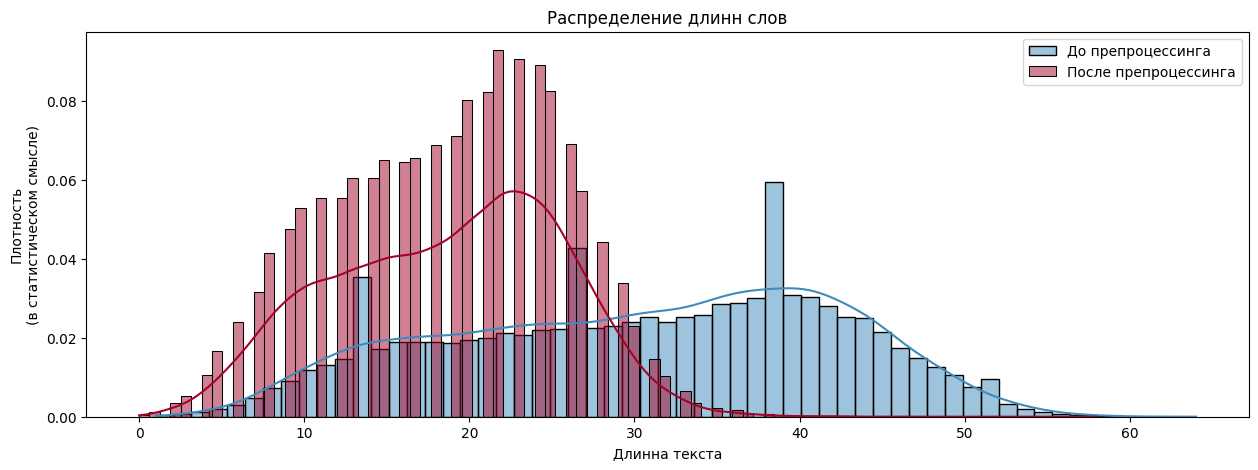

In [324]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['Text'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='До препроцессинга',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['Text_preprocessed'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='После препроцессинга',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн слов')
plt.show()

Исходя из график длину слова можно брать 40

## Леманизация

In [325]:
#Lemmatizing the text
def lemmatize_word(text):
    wnl = WordNetLemmatizer()
    text= ' '.join([wnl.lemmatize(word) for word in text.split()])
    return text

In [326]:
df['Text_lemma'] = df['Text_preprocessed'].apply(lemmatize_word)

In [327]:
df['length_text_lemma'] = df['Text_lemma'].apply(get_text_lenght)

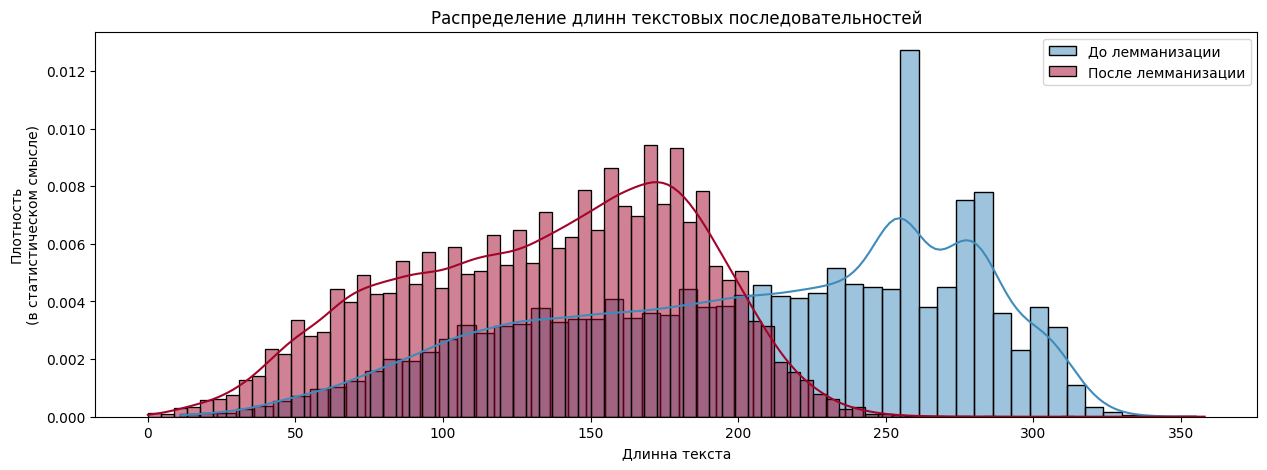

In [328]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['length_text'],
             ax=ax, kde=True,
             label='До лемманизации',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['length_text_lemma'],
             ax=ax, kde=True,
             label='После лемманизации',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн текстовых последовательностей')
plt.show()

Исходя из графика длину сообщения можно брать 250

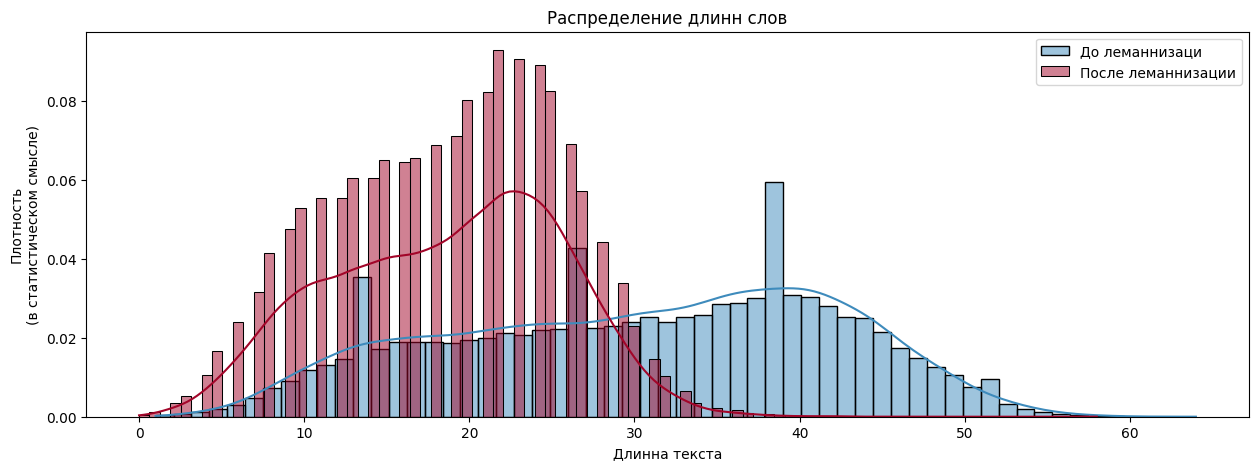

In [329]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['Text'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='До леманнизаци',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['Text_lemma'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='После леманнизации',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн слов')
plt.show()

Исходя из графика длину слова можно брать 40

## Cтемминг

In [330]:
#Stemming the text
def simple_stemmer(text):
    ps=SnowballStemmer(language='english')
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [331]:
df['Text_stemmer'] = df['Text_preprocessed'].apply(simple_stemmer)

In [332]:
df['length_text_stemmer'] = df['Text_stemmer'].apply(get_text_lenght)

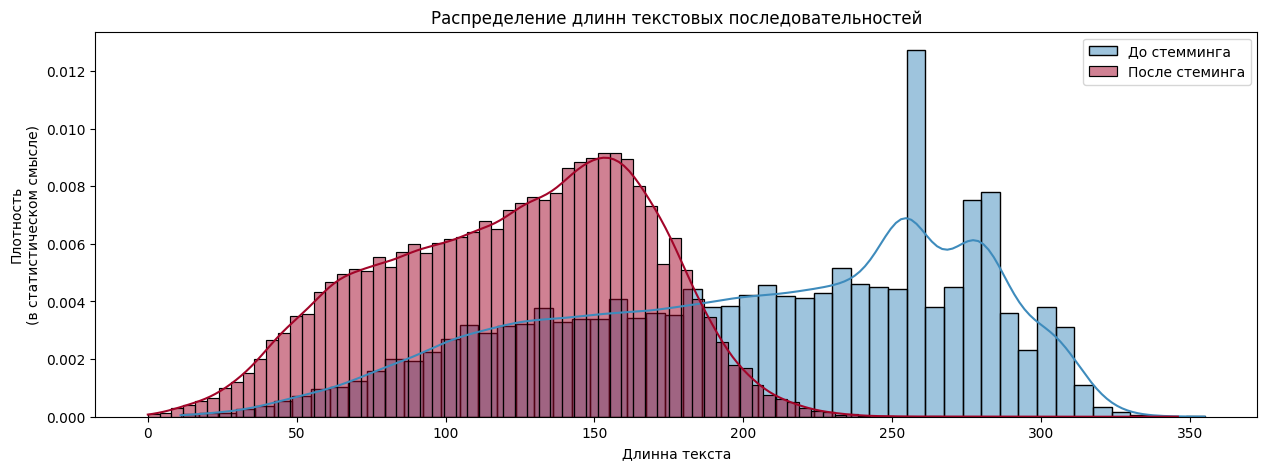

In [333]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['length_text'],
             ax=ax, kde=True,
             label='До стемминга',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['length_text_stemmer'],
             ax=ax, kde=True,
             label='После стеминга',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн текстовых последовательностей')
plt.show()

Исходя из графика длину сообщений можно брать 250

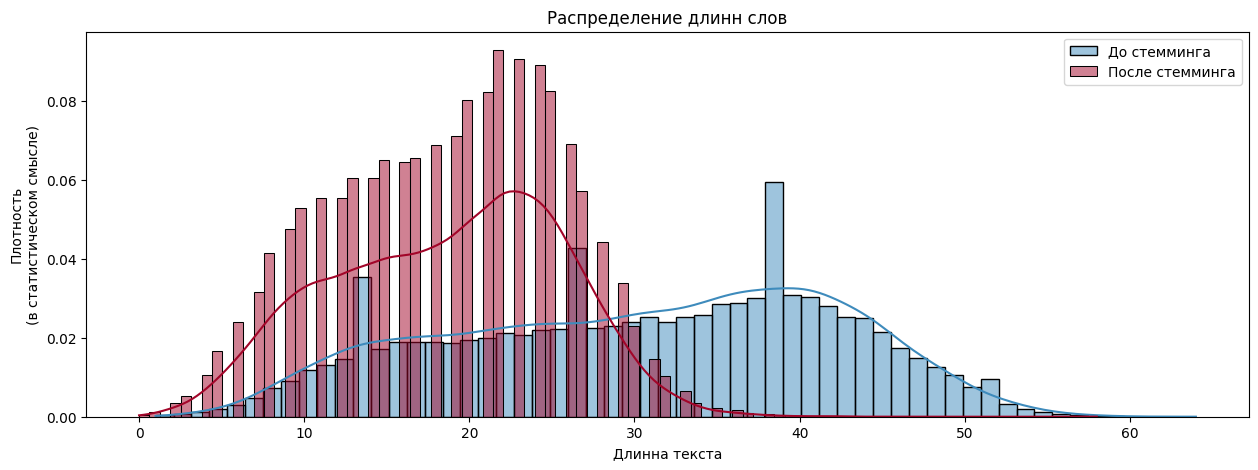

In [334]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['Text'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='До стемминга',
             color='#3e8bbc',
             stat='density')
sns.histplot(df['Text_stemmer'].str.split().map(lambda x: len(x)),
             ax=ax, kde=True,
             label='После стемминга',
             color='#a20529',
             stat='density')
plt.legend(loc='best')
ax.set_xlabel('Длинна текста')
ax.set_ylabel('Плотность\n(в статистическом смысле)')
plt.title('Распределение длинн слов')
plt.show()

Исходя из графика длину слова можно брать 40

По итогам препроцессинга видно, что распределение сдвинулась и приближаеться к нормальному. Ярковыроженных пиков не стало

# Логистические регрессии на мешках с костями=)

## Код модели

In [335]:
def get_LRM(columns):
    words = [item for sublist in df[columns].str.split()  for item in sublist]
    count_words = Counter(words)

    total_words = len(words)
    sorted_words = count_words.most_common(total_words)
    sorted_words[:10], print(f"В словаре {len(sorted_words)} уникальных слов")

    # Удаляем заголовки, фамилии, явки
    sorted_words = [(word,count) for (word,count) in sorted_words if count>1]

    vocab_to_int = {word:i+1 for i, (word, count) in enumerate(sorted_words)}
    sorted_words_for_emb = [count for count, i in sorted_words]
    MAX_VOCAB_SIZE  = len(sorted_words)

    # Кодируем слова
    def word_to_int(x):
      text_int = []
      for word in x.split():
        word = vocab_to_int.get(word, 0)
        text_int.append(word)
      return text_int

    # Обрезаем вектор
    def pad_features(x, seq_length):
      if len(x)<= seq_length:
        zeroes = np.zeros(seq_length-len(x))
        new = np.concatenate([zeroes,np.array(x)])
      else:
        new = np.array(x[0:seq_length])
      return new

    label_encoder = LabelEncoder()
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

    X_train, X_test, y_train, y_test = train_test_split(df[columns],
                                                      df['Sentiment'],
                                                      stratify=df['Sentiment'],
                                                      test_size=0.2,
                                                      random_state=SEED)

    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    X_train = X_train.apply(word_to_int)
    X_test = X_test.apply(word_to_int)

    X_train = X_train.apply(pad_features, seq_length = SEQ_LENGTH)
    X_test = X_test.apply(pad_features, seq_length = SEQ_LENGTH)

    # Преобразование текстовых данных в матрицу признаков
    vectorizer = CountVectorizer()
    X_train_matrix = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(map(str, x))))
    X_test_matrix = vectorizer.transform(X_test.apply(lambda x: ' '.join(map(str, x))))

    # Создание и обучение модели логистической регрессии
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_matrix, y_train)

    # Предсказание на тестовых данных
    y_pred = model.predict(X_test_matrix)

    # Вывод результатов
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [336]:
SEED = 42
SEQ_LENGTH = 45

## Модель после препроцессинга

In [337]:
get_LRM('Text_preprocessed')

В словаре 58668 уникальных слов
Accuracy: 0.5996841210059531

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.63      1096
           1       0.69      0.62      0.66      1325
           2       0.53      0.53      0.53      1983
           3       0.63      0.70      0.66      1542
           4       0.56      0.58      0.57      2285

    accuracy                           0.60      8231
   macro avg       0.62      0.61      0.61      8231
weighted avg       0.60      0.60      0.60      8231



##Модель после леманизации

In [338]:
get_LRM('Text_lemma')

В словаре 54929 уникальных слов
Accuracy: 0.6085530312234236

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      1096
           1       0.71      0.63      0.67      1325
           2       0.55      0.54      0.54      1983
           3       0.63      0.71      0.67      1542
           4       0.57      0.59      0.58      2285

    accuracy                           0.61      8231
   macro avg       0.63      0.61      0.62      8231
weighted avg       0.61      0.61      0.61      8231



##Модель после стемминга

In [339]:
get_LRM('Text_stemmer')

В словаре 48182 уникальных слов
Accuracy: 0.6080670635402746

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64      1096
           1       0.72      0.65      0.68      1325
           2       0.53      0.52      0.52      1983
           3       0.63      0.70      0.67      1542
           4       0.57      0.60      0.58      2285

    accuracy                           0.61      8231
   macro avg       0.63      0.62      0.62      8231
weighted avg       0.61      0.61      0.61      8231



**Вывод: Используя простую логистическую регрессию, мешок, препроцессинг-стеминг показатель скорость-качество лучше, чем только при препроцессенгие и препроцессинг-лемитизация**